In [1]:
import matplotlib.pyplot as plt
from PIL import Image
from tifffile import imread
import numpy as np
from skimage.color import label2rgb
from skimage.transform import resize

from os import getcwd
CWD = getcwd()
FIG_DATA = '/'.join(CWD.split('/')[:-1] + ['figures/fig_data'])
print(FIG_DATA)

/home/ronan/HR-Dv2/notebooks/figures/fig_data


In [2]:
def tiff_to_labels(tiff: np.ndarray, rev: bool=False) -> np.ndarray:
    if tiff.shape[0] == 1:
        tiff = tiff[0]
    out = tiff
    vals = np.unique(tiff)[::-1] if rev else np.unique(tiff)
    for i, val in enumerate(vals):
        out = np.where(tiff == val, i, out)
    return out

In [3]:
cmap = [
            "#fafafa",
            "#1f77b4",
            "#ff7f0e",
            "#2ca02c",
            "#d62728",
        ]
color_list = [[255, 255, 255], [44, 160, 44], [255, 127, 14], [31, 119, 180], [255, 0, 0]]
COLORS = np.array(color_list) / 255.0

In [4]:
cell = imread(f'{FIG_DATA}/cell.tif')
labels = Image.open(f'{FIG_DATA}/labels.png')
gt = tiff_to_labels(imread(f'{FIG_DATA}/mask.tif'), True)

dv2_seg = tiff_to_labels(imread(f'{FIG_DATA}/dinov2_seg.tiff'))
rf_seg = tiff_to_labels(imread(f'{FIG_DATA}/rf_seg_no_crf.tiff'))

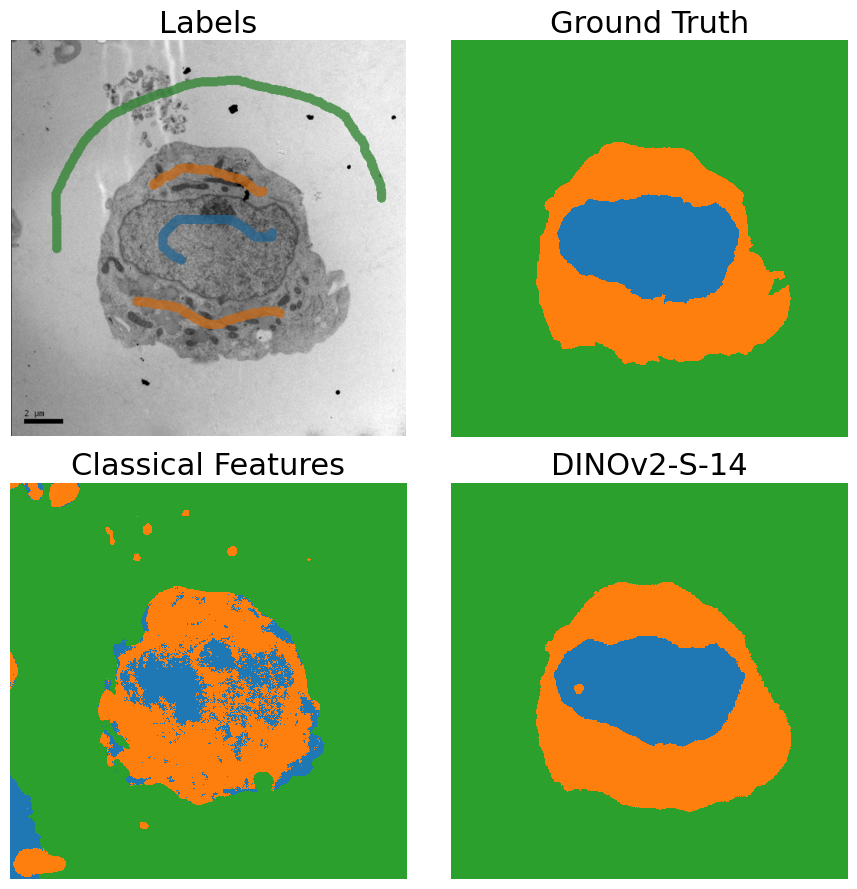

In [5]:
fig, axs = plt.subplots(nrows=2, ncols=2)

fig.set_size_inches(9, 9)
plt.rcParams["font.family"] = "serif"

axs[0, 0].imshow(labels)
axs[0, 0].set_title('Labels', fontsize=22)
axs[0, 1].imshow(gt, cmap='tab10', interpolation='nearest', vmin=0, vmax=10)
axs[0, 1].set_title('Ground Truth', fontsize=22)
axs[1, 0].imshow(rf_seg, cmap='tab10', interpolation='nearest', vmin=0, vmax=10)
axs[1, 0].set_title('Classical Features', fontsize=22)
axs[1, 1].imshow(dv2_seg, cmap='tab10', interpolation='nearest', vmin=0, vmax=10)
axs[1, 1].set_title('DINOv2-S-14', fontsize=22)

for row in axs:
    for col in row:
        col.set_axis_off()

plt.tight_layout()

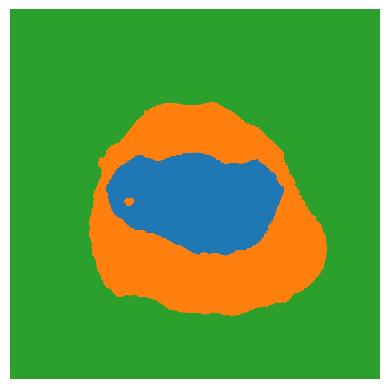

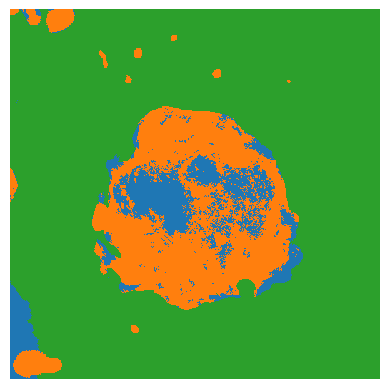

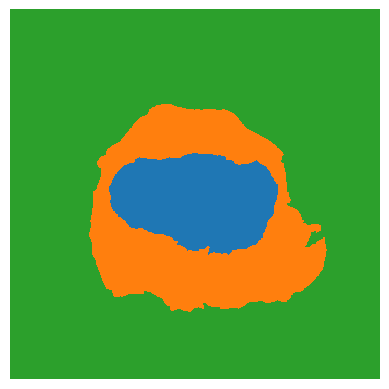

In [6]:
fig = plt.figure('dino_pred')
fig.gca().imshow(dv2_seg, cmap='tab10', interpolation='nearest', vmin=0, vmax=10)
fig.gca().set_axis_off()
plt.savefig('dino_pred.png')

fig = plt.figure('rf_pred')
fig.gca().imshow(rf_seg, cmap='tab10', interpolation='nearest', vmin=0, vmax=10)
fig.gca().set_axis_off()
plt.savefig('rf_pred.png')

fig = plt.figure('gt')
fig.gca().imshow(gt, cmap='tab10', interpolation='nearest', vmin=0, vmax=10)
fig.gca().set_axis_off()
plt.savefig('gt.png')

In [7]:
def remap_label_arr(arr: np.ndarray) -> np.ndarray:
    if arr.shape[0] == 1:
        arr = arr[0]
    return (arr // np.unique(arr)[0]) - 1

def centre_crop(img_or_arr: np.ndarray |  Image.Image, cw: int, ch: int) -> np.ndarray | Image.Image:
    if type(img_or_arr) == np.ndarray:
        arr: np.ndarray = img_or_arr #type:ignore
        ih, iw = arr.shape
        oy, ox = (ih - ch) // 2, (iw - cw) // 2
        cropped = arr[oy:oy+ch, ox:ox+cw]
        return cropped
    else:
        img: Image.Image = img_or_arr #type: ignore
        ih, iw = img.height, img.width
        oy, ox = (ih - ch) // 2, (iw - cw) // 2
        bbox = (ox, oy, ox + cw, oy + ch)
        return img.crop(bbox)


In [8]:
from types import NoneType

def add_inset_zoom(xywh: list[int], fig_xywh: list[float], img_arr: np.ndarray, labels: np.ndarray | None, ax ) -> object:
    x0, y0, w, h = xywh
    fx, fy, fw, fh = fig_xywh
    H, W, C = img_arr.shape
    inset_data = np.zeros_like(img_arr)
    inset_data[y0:y0+h, x0:x0+w, :] = img_arr[y0:y0+h, x0:x0+w, :]

    extent = (0, H, W, 0)
    # 418 / 518, 0 / 518, 150 / 518, 150 / 518
    axin = ax.inset_axes(
        fig_xywh, xlim=(x0, x0+w), ylim=(y0, y0+h))
    axin.set_xticks([])
    axin.set_yticks([])
    #axin.set_axis_off()
    if type(labels) != NoneType:
        inset_data = label2rgb(labels, img_arr, COLORS[1:], kind='overlay', alpha=0.6, bg_label=-1)
        axin.imshow(inset_data,)
    else:
        axin.imshow(inset_data, cmap="binary_r",) # cmap="binary_r"
    ax.indicate_inset_zoom(axin, edgecolor="black", lw=2)
    axin.set_ylim((y0 + h, y0))

    axin.patch.set_edgecolor('black')  

    axin.patch.set_linewidth(4)  

    return axin

(434, 518) (434, 518)
(434, 518) (434, 518)
(434, 518) (434, 518)
(434, 518) (434, 518)
(434, 518) (434, 518)
(434, 518) (434, 518)


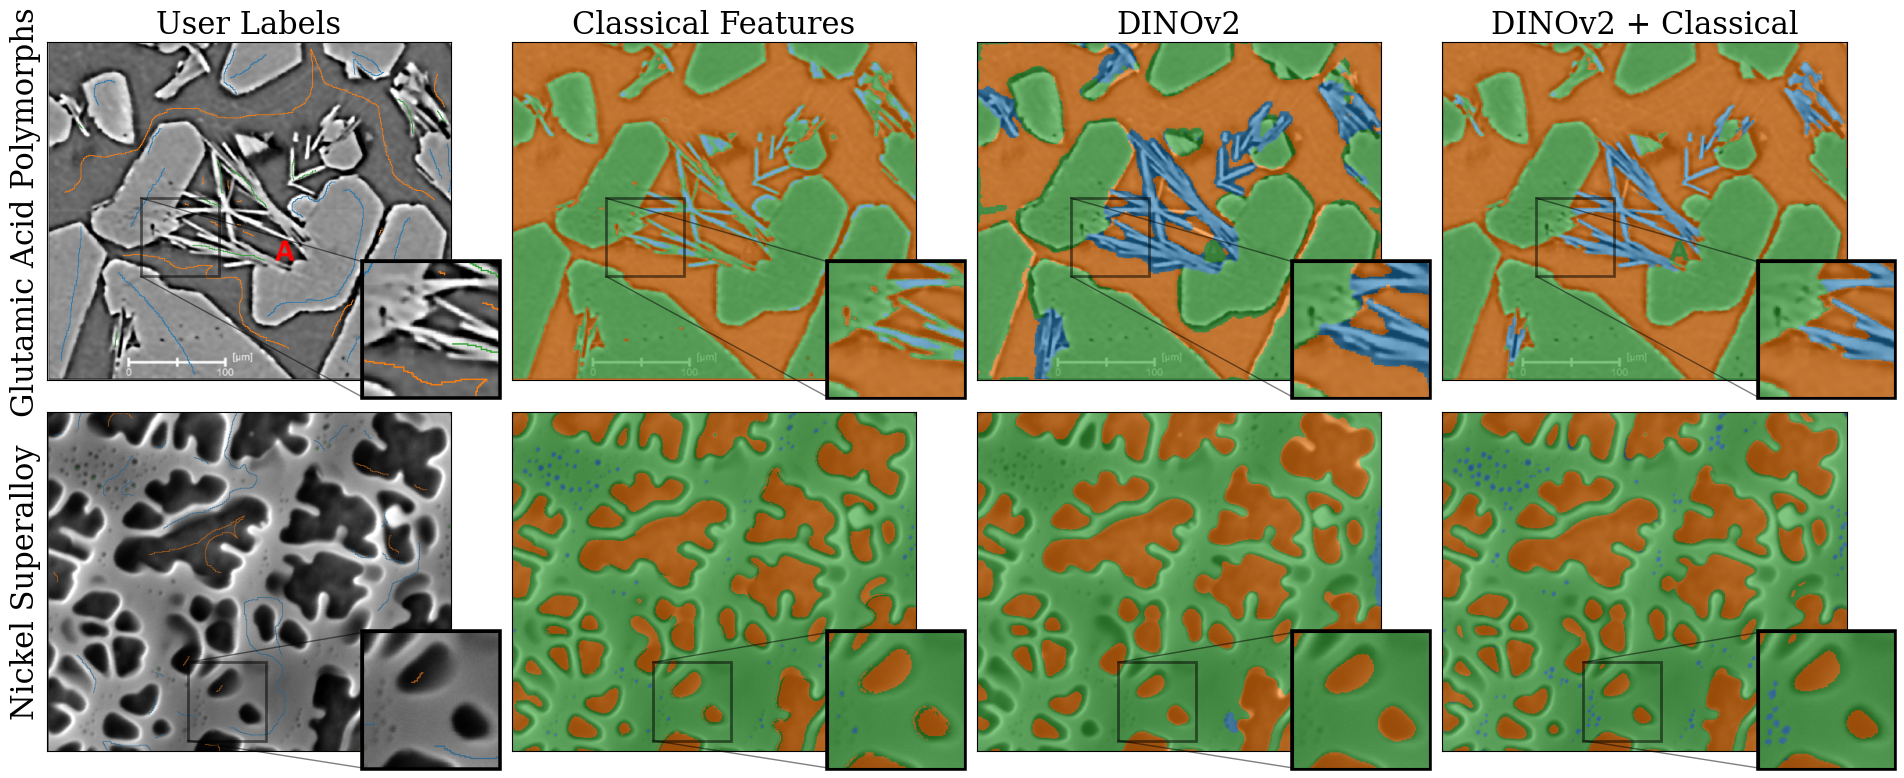

In [9]:
folder_names = ["needle_block", "superalloy",]
prefix = f"{FIG_DATA}/wss_data/examples"
paths = [f"{prefix}/{i}" for i in folder_names ]

n_examples = len(folder_names)
fig, axs = plt.subplots(nrows=n_examples, ncols=4)
fig.set_size_inches(4.5 * 4, 4.5 * n_examples)
plt.rcParams["font.family"] = "serif"

file_prefix = ["needle", "super",]
type_suffix = ["rf_nocrf", "dv2_nocrf", "hybrid_nocrf"]
titles = ["Glutamic Acid Polymorphs", "Nickel Superalloy", "NMC cathode"]
row_titles = ["User Labels", "Classical Features", "DINOv2", "DINOv2 + Classical"]

glut_bbox = [120, 200, 100, 100]
ni_bbox = [180, 320, 100, 100]
nmc_bbox = [180, 250, 100, 100]
bboxes = [glut_bbox, ni_bbox, nmc_bbox]

min_h, min_w = (1000, 1000)
for col in range(2):
    arr = imread(f"{paths[col]}/{file_prefix[col]}_{type_suffix[0]}.tiff")
    if arr.shape[0] == 1:
        arr = arr[0]
    ih, iw = arr.shape
    if col < 2:
        min_h = np.min((ih, min_h))
        min_w = np.min((iw, min_w))

labels_img_arrs = []
img_arrs = []

for row in range(n_examples):
    img = Image.open(f"{paths[row]}/image.jpg").convert('L')
    img_arr = np.array(img)
    for col in range(len(type_suffix) + 1):
        ax = axs[row, col]
    
        if col == 0:
            labels_added = Image.open(f"{paths[row]}/labels.png")
            labels_added = centre_crop(labels_added, min_w, min_h)
            labels_img_arrs.append(np.array(labels_added.convert('RGB')))
            ax.imshow(labels_added)
            ax.set_ylabel(titles[row], fontsize=22)
            #ax.set_title(titles[col], fontsize=22)

        else:
            low_res_data = imread(f"{paths[row]}/{file_prefix[row]}_{type_suffix[col - 1]}.tiff")
            
            low_res_data = remap_label_arr(low_res_data)
            data_cropped = centre_crop(low_res_data, min_w, min_h)
            data = data_cropped.astype(np.uint8)
            labels = tiff_to_labels(data)
            
            h, w = low_res_data.shape

            img_r = img.resize((w, h))
            if row != 2:
                img_r = centre_crop(img_r, min_w, min_h)
            img_arr_r = np.array(img_r)

            if col == 1:
                fake_rgb = np.expand_dims(img_arr_r, -1)
                img_arrs.append(np.repeat(fake_rgb, 3, axis=-1) )
            
            print(labels.shape, img_arr_r.shape)

            overlay = label2rgb(labels, img_arr_r, COLORS[1:], kind='overlay', alpha=0.6, bg_label=-1)
            ax.imshow(overlay)
        
        zoom_labels = labels if col > 0 else None
        inset_arr = img_arrs[row] if col > 0 else labels_img_arrs[row]
        add_inset_zoom(bboxes[row], [0.75, -0.05, 0.4, 0.4], inset_arr, zoom_labels, ax )

        if row == 0:
            ax.set_title(row_titles[col], fontsize=22)
        ax.set_xticks([])
        ax.set_yticks([])

plt.tight_layout()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = -0.3, wspace = 0.15)
save_path = '/'.join(CWD.split('/')[:-1] + ['figures/fig_out'])
plt.savefig(f"{save_path}/wss_examples.png")